In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
import glob
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sn
import os
import csv
import numpy as np
import tensorflow as tf

In [3]:
def read_user_data():
    """
    A function that reads all the user data and prepares them for future use
    :return: a list of all the user data
    """
    
    # path of the dataset
    path = './EMG_data_for_gestures-master/'  
    
    # a list holding the data for all 36 users
    user_data = []

    for i in range(36):  # since there are 36 users
        all_files = glob.glob(path + "{}/*.txt".format(i+1))
        
        # two files for each user, hence two dataframes
        file = [pd.DataFrame() for _ in range(2)]
        
        # read both files for each user
        for j, filename in enumerate(all_files):
            file[j] = pd.read_csv(filename, sep = "\t")
            
        merged_df = pd.concat([file[0], file[1]], axis=0, ignore_index=True)
        #merged_df = file[0]
        
        #user_data.append(merged_df.sort_values(by=['time']))
        user_data.append(merged_df)
        
    return user_data

In [4]:
def get_summary_stats(user_data):
    """
    A function that computes the summary statistics of the list of user_data
    """

    columns = ["mean", "SD", "min", "max"]

    summary_stats = []
    for user in user_data:
        means = user.mean(axis=0).to_frame()
        std = user.std(axis=0).to_frame()
        mini = user.min(axis=0).to_frame()
        maxm = user.max(axis=0).to_frame()
        result = pd.concat([means, std, mini, maxm], axis=1, ignore_index=True)
        result.columns = columns
        summary_stats.append(result)

    f = open("summary_stats.txt", "w+")
    f.write("Summary stats for all users\n\n")

    for i, summary in enumerate(summary_stats):
        f.write("---- user {} ----\n".format(i+1))
        f.write(str(summary))
        f.write("\n\n")

    f.close()
    

In [5]:
def get_class_distribution(user_data):
    counts = []
    
    f = open("class_distribution.txt", "w+")
    f.write("Class distributions stats for all users\n\n")
    
    for i, user in enumerate(user_data):
        f.write("---- user {} ----\n".format(i+1))
        count = pd.DataFrame(user['class'].value_counts())
        f.write(str(count))
        f.write("\n\n")
        counts.append(count)
        
    f.close()
        
    return counts

In [6]:
# get all the user data
user_data = read_user_data()

# drop null values
for user in user_data:
    user.dropna(inplace=True)

In [7]:
get_summary_stats(user_data)

In [8]:
class_dis = get_class_distribution(user_data)

In [9]:
def normalize_data(user_data):

    # concatenate all the user data
    df = pd.concat(user_data)

    # the time column
    tim = pd.DataFrame(df['time'])

    # the class column
    clas = pd.DataFrame(df['class'])

    # drop time from the dataset so that we don't scale the timestamps
    df.drop(['time', 'class'], axis=1, inplace=True)

    # Get the headers from the list
    headers = list(df)

    scaler = StandardScaler()
    scaled_values = pd.DataFrame(scaler.fit_transform(df), columns = headers, index = df.index)
    
    # concatenate the data after scaling it
    df_new = pd.concat([tim, clas, scaled_values], axis=1)
    df_new = df_new.astype({'class': 'int32'})
    
    return df_new

In [10]:
normalized_data = normalize_data(user_data)
normalized_data

,time,class,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8
0,1,0,0.109812,-0.088774,-0.003634,-0.090189,0.058723,0.003975,0.061315,-0.001761
1,5,0,0.109812,-0.088774,-0.003634,-0.090189,0.058723,0.003975,0.061315,-0.001761
2,6,0,-0.012804,0.162855,0.237942,0.042688,0.095431,-0.042506,-0.004160,0.114455
3,7,0,-0.012804,0.162855,0.237942,0.042688,0.095431,-0.042506,-0.004160,0.114455
4,8,0,-0.012804,0.162855,0.237942,0.042688,0.095431,-0.042506,-0.004160,0.114455
...,...,...,...,...,...,...,...,...,...,...
101749,50962,0,0.109812,-0.004898,-0.084159,-0.134481,-0.381775,0.050457,0.192264,0.172563
101750,50963,0,0.109812,-0.004898,-0.084159,-0.134481,-0.381775,0.050457,0.192264,0.172563
101751,50964,0,0.109812,-0.004898,-0.084159,-0.134481,-0.381775,0.050457,0.192264,0.172563
101752,50965,0,0.109812,-0.004898,-0.084159,-0.134481,-0.381775,0.050457,0.192264,0.172563


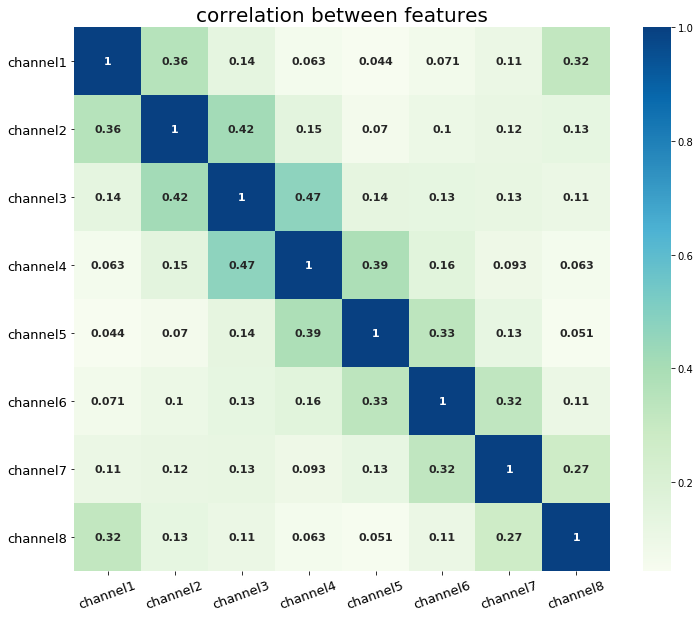

In [11]:
cor = normalized_data.iloc [0: , 2:]


# calculate the correlation matrix
corr = cor.corr()
corr.to_csv('correlation.csv')

# plot the heatmap
plt.figure(1, figsize=(12, 10))

ax = sn.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, annot_kws={"fontsize":11, "weight": "bold"}, cmap="GnBu")
ax.set_title('correlation between features', fontsize=20)

plt.xticks(rotation=20, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# for tick in ax.get_xticklabels():
#     tick.set_rotation(90)


plt.savefig('corr_plot.png', dpi=500)
plt.show()

In [12]:
for i in range(36):
    plt.figure(i, figsize=(20, 22))
    ax2 = normal_data[i].plot(x='time', y='class', kind='scatter')
    ax2.set_title('Distribution of classes', fontsize=20)
    #plt.xlim(0, 10000)
    folder = "./drive/My Drive/EMG_data_for_gestures-master/images/test/"
    os.makedirs(folder, exist_ok=True)
    plt.savefig('{}class_{}.png'.format(folder, i + 1), dpi=500)
    plt.show()
    break

NameError: name 'normal_data' is not defined

<Figure size 1440x1584 with 0 Axes>

In [31]:
def normalize_df(df):
    # the time column
    tim = pd.DataFrame(df['time'])

    # the class column
    clas = pd.DataFrame(df['class'])

    # drop time from the dataset so that we don't scale the timestamps
    df_new = df.drop(['time', 'class'], axis=1)

    # Get the headers from the list
    headers = list(df_new)

    scaler = StandardScaler()
    scaled_values = pd.DataFrame(scaler.fit_transform(df_new), columns = headers, index = df_new.index)
    
    # concatenate the data after scaling it
    df_updated = pd.concat([tim, clas, scaled_values], axis=1)
    df_updated = df_updated.astype({'class': 'int32'})
    return df_updated

# normal_data = []
# folder = "normalized"
# os.makedirs(folder, exist_ok=True)
# for i, df in enumerate(user_data):
#     new_df = df[df["class"] < 7]
#     #new_df = df[df["class"] > 0]
#     normalized_df = normalize_df(new_df)
#     #normalized_df.to_csv("./{}/{}.csv".format(folder, i + 1))
#     normal_data.append(normalized_df)

In [32]:
def get_square_df(df):
    new_df = df.pow(2)
    # the time column
    tim = pd.DataFrame(df['time'])

    # the class column
    clas = pd.DataFrame(df['class'])

    # drop time from the dataset so that we don't scale the timestamps
    new_df.drop(['time', 'class'], axis=1, inplace=True)

    # concatenate the data after scaling it
    new_df = pd.concat([tim, clas, new_df], axis=1)
    new_df = new_df.astype({'class': 'int32'})
    return new_df

def RMS(df, start, end):
    return df.iloc[start:end + 1, :].mean()

def partition_window(df, window_size=200, step_size=100):
    count = 0
    rows, columns = df.shape
    last_data = []
    start = 0
    end = 0
    square_df = get_square_df(df)
    RMS_list = []
    window_list = []
    
    for i in range(0, rows, step_size):
        if end > 0:
            start = end - step_size + 1
        else:
            start = i
        end = min(i + window_size - 1, rows - 1)
        #count += 1 # count of total possible windows we can have
        #print("{} to {}".format(start, end))
        res = RMS(square_df, start, end)
        if res[1] == int(res[1]) and int(res[1]) > 0 and int(res[1]) < 7 and end - start + 1 == window_size:
            RMS_list.append(res)
            window_list.append([start, end])
        if end - start + 1 < window_size:
            count += 1
        if end == rows - 1:
            break
    return window_list, RMS_list, count

In [33]:
# print("Total: {}, left: {}, lost percentage: {}".format(total_window, count, (1 - count/total_window) * 100 ))

In [34]:
# print("Total: {}, left: {}, lost percentage: {}".format(total_window, count, (1 - count/total_window) * 100 ))

In [35]:
# new_df = df.pow(2)
# # the time column
# tim = pd.DataFrame(df['time'])

# # the class column
# clas = pd.DataFrame(df['class'])

# # drop time from the dataset so that we don't scale the timestamps
# new_df.drop(['time', 'class'], axis=1, inplace=True)

# # concatenate the data after scaling it
# new_df = pd.concat([tim, clas, new_df], axis=1)
# new_df = new_df.astype({'class': 'int32'})
# res = new_df.iloc[start:end + 1, :].mean()

In [36]:
def exportCSV(data, fileName='output.csv'):
    """
    data is a list storing the data to be appended to the csv fileName
    """
    with open(fileName, 'a+', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        spamwriter.writerow(data)

# train, test split
def train_valid_test_split(path = './EMG_data_for_gestures-master/'):
    test_file = 1 # 1 for using the first half of the second text file
    num_subject = 36 # number of subjects we have 
    # find all the changing points first, 
    # then use the first changing point from 6 to 0 minus 1 to be the row to split.
    # split the data into train and test, then return list of dataframes
    # a list holding the data for all 36 users
    log_file = path + '{}.csv'.format("change_points")
    change_points = [[] for i in range(num_subject)]
    is_loaded = False
    if os.path.isfile(log_file):
        # load the data
        count = 0
        with open(log_file, 'r') as fin:
            for line in fin:
                count += 1
                if count % 2 == 1:
                    continue
                data = list(map(int, line.strip().split(",")))
                change_points[(count - 1) // 4].append(data)
        is_loaded = True
        # for i in range(num_subject):
        #     print(change_points[i])

    training = []
    validation = []
    testing = []
    for i in range(num_subject):  # since there are 36 users
        all_files = glob.glob(path + "{}/*.txt".format(i+1))
        # read both files for each user
        for j, filename in enumerate(all_files):
            df = pd.read_csv(filename, sep = "\t")
            if not is_loaded:
                change_points[i].append([])
                last_class = 0
                classes = []
                for index, row in enumerate(df.itertuples(index=False)):
                    if row[-1] != last_class:
                        last_class = row[-1]
                        classes.append(last_class)
                        change_points[i][j].append(index)
                #print(classes)
                exportCSV(classes, log_file)
                #print(change_points[i][j])
                exportCSV(change_points[i][j], log_file)
            if j == test_file:
                #print("{}, {}".format(i, j))
                #print(change_points[i][j])
                split_point = change_points[i][j][11]
                # append first half to validation,
                # second half to testing
                validation.append(df.iloc[:split_point,:])
                testing.append(df.iloc[split_point:,:])
            else:
                # append this whole df to training
                training.append(df)
    return training, validation, testing

In [37]:
training, validation, testing = train_valid_test_split()

In [38]:
print(len(training))
print(len(validation))
print(len(testing))

36
36
36


In [64]:
# fit and evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test):
    """A function that trains an LSTM model and returns the accuracy on the test dataset.

    Parameters
    ----------
    X_train : numpy array
        Training data
    y_train : numpy array
        Training labels
    X_test : numpy array
        Testing data
    y_test : numpy array
        Testing labels

    Returns
    -------
        The accuracy of the trained and evaluated LSTM model.

    """
    verbose, epochs, batch_size = 0, 100, 32
    n_timesteps, n_features, n_outputs = 200, 8, y_train.shape[0]
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(100, input_shape=(n_timesteps,n_features)))     #(289,200)
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    # fit network
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    # evaluate model
    _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
    return accuracy

In [65]:
def getXY(df):
    # normalize this df
    df = normalize_df(df)
    # partition this df into windows
    window_list, RMS_list, count = partition_window(df)
    # get the X and y from RMS list
    rmsX = [list(i[2:]) for i in RMS_list]
    dataX = [df.iloc[window[0]:window[1] + 1,2:] for window in window_list]
    y = [i[1] for i in RMS_list]
    return rmsX, dataX, y

In [66]:
acc = []
for i in range(1):
    trainRMSX, trainX, trainY = getXY(training[i])
    validRMSX, validX, validY = getXY(validation[i])
    # combine validatation and training together
    trainX.extend(validX)
    trainY.extend(validY)

    # get the testing data
    testRMSX, testX, testY = getXY(testing[i])
    
    trainX = np.asarray([X.values for X in trainX])
    trainY = np.asarray(trainY)
    testX = np.asarray([X.values for X in testX])
    testY = np.asarray(testY)

    # train and test the model
    acc.append(evaluate_model(trainX, trainY, testX, testY))


Train on 289 samples
Epoch 1/100
289/289 [==============================] - 3s 10ms/sample - loss: 5.5718 - accuracy: 0.0450
Epoch 2/100
289/289 [==============================] - 1s 4ms/sample - loss: 5.2958 - accuracy: 0.2249
Epoch 3/100
289/289 [==============================] - 1s 4ms/sample - loss: 4.3936 - accuracy: 0.2422
Epoch 4/100
289/289 [==============================] - 1s 5ms/sample - loss: 2.4821 - accuracy: 0.1315
Epoch 5/100
289/289 [==============================] - 1s 4ms/sample - loss: 1.8758 - accuracy: 0.1938
Epoch 6/100
289/289 [==============================] - 1s 4ms/sample - loss: 1.8840 - accuracy: 0.1765
Epoch 7/100
289/289 [==============================] - 1s 4ms/sample - loss: 1.8517 - accuracy: 0.1799
Epoch 8/100
289/289 [==============================] - 1s 4ms/sample - loss: 1.8726 - accuracy: 0.1696
Epoch 9/100
289/289 [==============================] - 1s 4ms/sample - loss: 1.8723 - accuracy: 0.1903
Epoch 10/100
289/289 [=============================

289/289 [==============================] - 1s 5ms/sample - loss: 0.7108 - accuracy: 0.6990
Epoch 80/100
289/289 [==============================] - 1s 5ms/sample - loss: 0.7013 - accuracy: 0.6920
Epoch 81/100
289/289 [==============================] - 1s 5ms/sample - loss: 0.6773 - accuracy: 0.7370
Epoch 82/100
289/289 [==============================] - 1s 5ms/sample - loss: 0.6483 - accuracy: 0.7128
Epoch 83/100
289/289 [==============================] - 1s 4ms/sample - loss: 0.6343 - accuracy: 0.7232
Epoch 84/100
289/289 [==============================] - 1s 5ms/sample - loss: 0.8905 - accuracy: 0.6851
Epoch 85/100
289/289 [==============================] - 1s 5ms/sample - loss: 0.9405 - accuracy: 0.6332
Epoch 86/100
289/289 [==============================] - 1s 5ms/sample - loss: 0.9219 - accuracy: 0.6332
Epoch 87/100
289/289 [==============================] - 1s 5ms/sample - loss: 0.9052 - accuracy: 0.6644
Epoch 88/100
289/289 [==============================] - 1s 5ms/sample - loss:

In [67]:
acc

[0.66292137]

In [ ]:
#print(RMS_list[0])
#print(list(RMS_list[0][2:]))
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

In [ ]:
# window_list
# for window in window_list:
#     data = df.iloc[window[0]:window[1] + 1,2:]
#     break

In [ ]:
data

In [ ]:
# RMS_list[]

In [ ]:
window_list

In [ ]:
print(count)

In [ ]:
print(len(window_list))

In [ ]:
0.09/3

In [ ]:
for i in range(36):
    